***Import Libraries***

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)

***Hyper Parameters***

In [10]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

k = 2  #메시지 비트수
M = 2**k    #전송 가능한 메시지 수
n = 2   #인코딩 출력 차원

SNR_dB = 8
SNR = 10**(SNR_dB/10)
N = 1/SNR   #Noise std

num_msgs = 5000
learning_rate = 0.00017
num_epochs = 30000

ENC_MODEL_PATH = f"M={M}/Enc_M={M}_SNR={SNR_dB}.pth"
DEC_MODEL_PATH = f"M={M}/Dec_M={M}_SNR={SNR_dB}.pth"

In [11]:
import os

MODEL_DIR = f"M={M}"
try:
    os.makedirs(MODEL_DIR)
except FileExistsError:
    print('Directories not created because they already exist')

***Functions***

In [12]:
def Normalization(s):
    snorm = torch.linalg.norm(s, dim=1)
    snorm = torch.tile(snorm.unsqueeze(1), [1,n])
    snorm = snorm.to(device)
    return s/snorm


def Awgn(x, noise_var):
    noise = torch.randn((x.size(0),n))
    noise = noise.to(device)
    out = x + np.sqrt(noise_var) * noise
    return out


def one_hot_encoding(val):
    xx = torch.eye(M)
    xx = xx.to(device)
    return xx[val] 


def one_hot_decoding(prob):
    arg_list = []
    for p in prob:
        arg_max = torch.argmax(p)
        arg_list.append(arg_max)
        arg_list = list(map(int, arg_list))

    arg_list = torch.LongTensor(arg_list)
    encoded_arg_list = one_hot_encoding(arg_list)

    return encoded_arg_list

def Softmax(prob):
    softmax = nn.Softmax(dim=1)
    return softmax(prob)

***Model***

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(M, M),
            nn.ReLU(),
            nn.Linear(M, n)
        )

    def forward(self, s):
        out = self.encoder(s)
        return out


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(n, M),
            nn.ReLU(),
            nn.Linear(M, M)
        )

    def forward(self, y):
        out = self.decoder(y)
        return out


encoder = Encoder()    
decoder = Decoder()
encoder = encoder.to(device)  ###############
decoder = decoder.to(device)  ###############

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

***Train***

In [14]:
train_losses = []
test_losses = []
BLER = []
best_test_loss = 1

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    
    train_loss = 0
    test_loss = 0
    a = 0

    optimizer.zero_grad()

    while a != M:
        msg = torch.randint(0, M, (num_msgs,))#msg
        a = torch.max(msg) + 1

    msg = msg.to(device)
    
    s = one_hot_encoding(msg) #s
    encoded_s = encoder(s)  #x
    x = Normalization(encoded_s)
    y = Awgn(x, N)    #y
    p = decoder(y)
    
    loss = criterion(p, msg)

    train_loss += loss.item()
    train_losses.append(train_loss)

    loss.backward()
    optimizer.step()


    with torch.no_grad():
        a = 0
        err = 0

        while a != M:
            test_msg = torch.randint(0, M, (num_msgs,))#msg
            a = torch.max(test_msg) + 1

        test_msg = test_msg.to(device)

        test_s = one_hot_encoding(test_msg) #s
        test_encoded_s = encoder(test_s)  #x
        test_x = Normalization(test_encoded_s)
        test_y = Awgn(test_x, N)    #y
        test_p = decoder(test_y)

        loss = criterion(test_p, test_msg)

        test_loss += loss.item()
        test_losses.append(test_loss)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(encoder.state_dict(), ENC_MODEL_PATH)
            torch.save(decoder.state_dict(), DEC_MODEL_PATH)
            

    if epoch % 1000 == 0:
        p_soft = Softmax(test_p)
        s_hat = one_hot_decoding(p_soft)
        err = torch.sum(torch.abs(test_s - s_hat))/2

        print(f"[{epoch}/{num_epochs}] train loss : {train_loss} | test loss : {test_loss} | BLER : {err/num_msgs}")

[0/30000] train loss : 1.600731372833252 | test loss : 1.605759620666504 | BLER : 0.7411999702453613
[1000/30000] train loss : 1.2749141454696655 | test loss : 1.2823338508605957 | BLER : 0.5209999680519104
[2000/30000] train loss : 0.8978156447410583 | test loss : 0.8908403515815735 | BLER : 0.16380000114440918
[3000/30000] train loss : 0.6307387948036194 | test loss : 0.621244490146637 | BLER : 0.08899999409914017
[4000/30000] train loss : 0.44434115290641785 | test loss : 0.45445796847343445 | BLER : 0.08399999886751175
[5000/30000] train loss : 0.3384125828742981 | test loss : 0.3434635102748871 | BLER : 0.07639999687671661
[6000/30000] train loss : 0.28179195523262024 | test loss : 0.2888234555721283 | BLER : 0.08259999752044678
[7000/30000] train loss : 0.2424624264240265 | test loss : 0.2545818090438843 | BLER : 0.07759999483823776
[8000/30000] train loss : 0.22759723663330078 | test loss : 0.2173614203929901 | BLER : 0.07499999552965164
[9000/30000] train loss : 0.2163087576627

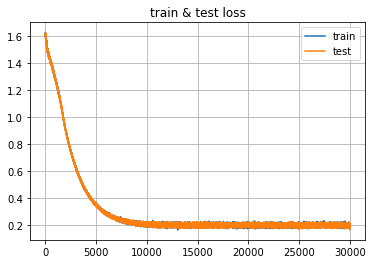

In [15]:
plt.plot(train_losses, label = "train")
plt.plot(test_losses, label = "test")

plt.title("train & test loss")
plt.legend()
plt.grid()

plt.show()


***Constellation Points***

[[-0.23743759  0.9714028 ]
 [ 0.26615342 -0.96393067]
 [ 0.95844775  0.28526825]
 ...
 [ 0.95844775  0.28526825]
 [-0.23743759  0.9714028 ]
 [ 0.95844775  0.28526825]]


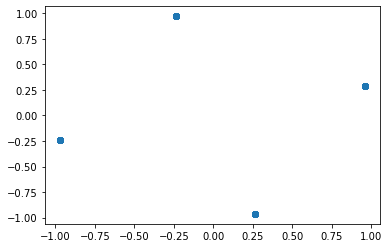

In [16]:
s = one_hot_encoding(msg) #s
encoded_s = encoder(s)  #x
x = Normalization(encoded_s)

x = x.cpu().detach().numpy()
print(x)
plt.scatter(x[:, 0], x[:, 1])
plt.show()